# Bert Finetune for hatespeech detection task
---
Dataset: HateSpeechDatasetBalanced.csv   ______________________     Model: Bert Base uncased _________________          epochs: 3   


In [2]:
# ai
import torch
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer

# Load dataset
df = pd.read_csv("HateSpeechDatasetBalanced.csv")  

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["Content"], padding="max_length", truncation=True, max_length=128)

# Convert dataset to Hugging Face format
dataset = Dataset.from_pandas(df)

# Rename "Label" to "labels"
dataset = dataset.map(lambda x: {"labels": x["Label"]}, remove_columns=["Label"])

# Tokenize dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Train-test split
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.1)
train_dataset = tokenized_dataset["train"]
val_dataset = tokenized_dataset["test"]


Map: 100%|█████████████████████████████████████████████████| 726119/726119 [03:35<00:00, 3370.51 examples/s]


In [3]:
# ai
import torch
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import shutil
import subprocess


# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.gradient_checkpointing_enable()


output_dir = "./bert-hate-speech2"

training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    bf16=True,
    gradient_accumulation_steps=2,
    optim="adamw_torch_fused",
    logging_dir="./logs",
    logging_steps=200,
    report_to="none",
    save_total_limit=2,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    fp16_full_eval=True,
    remove_unused_columns=False,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Start training
trainer.train()



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/atharva/anaconda3/envs/venv/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.220600,0.216841
2,0.066700,0.245783


Uploading ./bert-hate-speech.zip to Google Drive folder: Bert finetuned/
Upload failed: Command '['rclone', 'copy', './bert-hate-speech.zip', 'gdrive:/Bert finetuned//']' returned non-zero exit status 1.


2025/03/13 09:38:39 Failed to create file system for "gdrive:/Bert finetuned//": didn't find section in config file


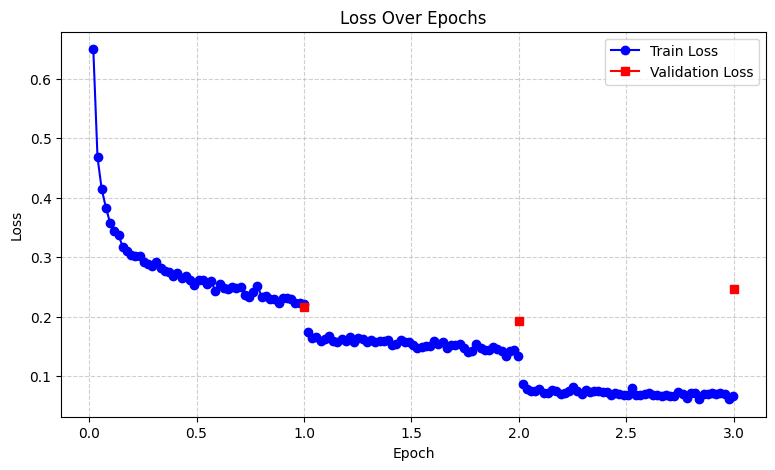

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract log history from Trainer
log_history = trainer.state.log_history

# Convert to DataFrame
log_df = pd.DataFrame(log_history)

# Keep only loss and accuracy values
log_df = log_df.dropna(subset=["epoch"], how="any")

# Plot Training Loss & Validation Loss
plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(log_df["epoch"], log_df["loss"], label="Train Loss", marker="o", linestyle="-", color="blue")
plt.plot(log_df["epoch"], log_df["eval_loss"], label="Validation Loss", marker="s", linestyle="-", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)



plt.show()
